# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [113]:
import numpy as np
import os
from skimage import io,transform

import datetime


In [141]:
tf. __version__

'2.14.0'

We set the random seed so that the results don't vary drastically.

In [114]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [165]:
train_doc = np.random.permutation(open('/Users/rishismac/Downloads/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/Users/rishismac/Downloads/Project_data/val.csv').readlines())
batch_size =33

In [166]:
train_doc=train_doc[:660]
val_doc=val_doc[:99]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [167]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,2)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,15,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    resizedImage = transform.resize(image, (120, 120,3))
                    
                    ## Data Augmentation:
                    
                    
                    

                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    
                    batch_data[folder,idx,:,:,0] = (resizedImage[:,:,0]-np.min(resizedImage[:,:,0]))/((np.max(resizedImage[:,:,0])-np.min(resizedImage[:,:,0])))
                    batch_data[folder,idx,:,:,1] = (resizedImage[:,:,1]-np.min(resizedImage[:,:,1]))/((np.max(resizedImage[:,:,1])-np.min(resizedImage[:,:,1])))
                    batch_data[folder,idx,:,:,2] = (resizedImage[:,:,2]-np.min(resizedImage[:,:,2]))/((np.max(resizedImage[:,:,2])-np.min(resizedImage[:,:,2])))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [168]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/rishismac/Downloads/Project_data/train'
val_path = '/Users/rishismac/Downloads/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 660
# validation sequences = 99
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [169]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers



In [170]:
model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=(15,100,100,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(5,activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [171]:
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_37 (Conv3D)          (None, 15, 100, 100, 16   400       
                             )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 7, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_38 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 max_pooling3d_37 (MaxPooli  (None, 3, 25, 25, 32)     0         
 ng3D)                                                           
                                                                 
 conv3d_39 (Conv3D)          (None, 3, 25, 25, 64)     16448     
                                                     

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [172]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)


In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [173]:
# To make sure that you have "at least steps_per_epoch * epochs batches", set the steps_per_epoch to

# steps_per_epoch = len(X_train)//batch_size

# validation_steps = len(X_test)//batch_size # if you have validation data 

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [174]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /Users/rishismac/Downloads/Project_data/train ; batch size = 33
Epoch 1/20
20/20 [==============================] - 99s 5s/step - loss: 1.6917 - accuracy: 0.1924 - val_loss: 1.5563 - val_accuracy: 0.3434
Epoch 2/20
20/20 [==============================] - 93s 5s/step - loss: 1.4661 - accuracy: 0.3606 - val_loss: 1.2778 - val_accuracy: 0.5253
Epoch 3/20
20/20 [==============================] - 119s 6s/step - loss: 1.1365 - accuracy: 0.5242 - val_loss: 1.1643 - val_accuracy: 0.5051
Epoch 4/20
20/20 [==============================] - 99s 5s/step - loss: 0.8817 - accuracy: 0.6364 - val_loss: 0.9489 - val_accuracy: 0.6364
Epoch 5/20
20/20 [==============================] - 96s 5s/step - loss: 0.6100 - accuracy: 0.7742 - val_loss: 0.8374 - val_accuracy: 0.7071
Epoch 6/20
20/20 [==============================] - 95s 5s/step - loss: 0.4315 - accuracy: 0.8379 - val_loss: 0.7002 - val_accuracy: 0.6566
Epoch 7/20
20/20 [==============================] - 102s 5s/step - loss: 0.3557 

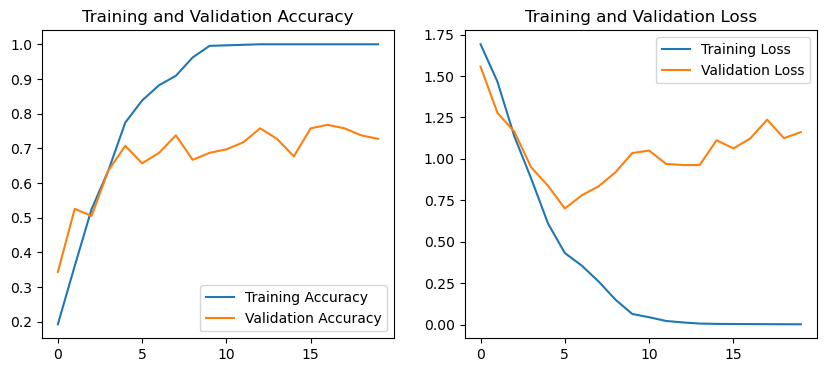

In [176]:
# Visualizing the Model results:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As can be seen there is quite some amount of overfitting in the data.

In [178]:
from keras.layers import Dropout

In [179]:
model=Sequential()
#layer1:

model.add(Conv3D(16,kernel_size=(2,2,2),strides=(1,1,1),padding='same',input_shape=(15,100,100,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))


#layer2:
model.add(Conv3D(32,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))



#layer3:
model.add(Conv3D(64,kernel_size=(2,2,2),strides=(1,1,1),padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.2))




#Flatten:
model.add(Flatten())

#Dense Connections:
model.add(Dense(512,activation='relu'))


model.add(Dense(5,activation='softmax'))


In [180]:
optimiser='adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_41 (Conv3D)          (None, 15, 100, 100, 16   400       
                             )                                   
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 7, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 dropout (Dropout)           (None, 7, 50, 50, 16)     0         
                                                                 
 conv3d_42 (Conv3D)          (None, 7, 50, 50, 32)     4128      
                                                                 
 max_pooling3d_41 (MaxPooli  (None, 3, 25, 25, 32)     0         
 ng3D)                                                           
                                                     

In [181]:
history=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                     validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
20/20 [==============================] - 104s 5s/step - loss: 2.2257 - categorical_accuracy: 0.1955 - val_loss: 1.6001 - val_categorical_accuracy: 0.2121
Epoch 2/20
20/20 [==============================] - 91s 5s/step - loss: 1.5975 - categorical_accuracy: 0.2258 - val_loss: 1.6089 - val_categorical_accuracy: 0.2020
Epoch 3/20
20/20 [==============================] - 99s 5s/step - loss: 1.5760 - categorical_accuracy: 0.2470 - val_loss: 1.5597 - val_categorical_accuracy: 0.3030
Epoch 4/20
20/20 [==============================] - 100s 5s/step - loss: 1.5058 - categorical_accuracy: 0.3318 - val_loss: 1.4698 - val_categorical_accuracy: 0.4141
Epoch 5/20
20/20 [==============================] - 94s 5s/step - loss: 1.4034 - categorical_accuracy: 0.4030 - val_loss: 1.3796 - val_categorical_accuracy: 0.5354
Epoch 6/20
20/20 [==============================] - 97s 5s/step - loss: 1.1843 - categorical_accuracy: 0.5318 - val_loss: 1.1599 - val_categorical_accuracy: 0.5455
Epoch 7/20
20/

In [186]:
history.history

{'loss': [2.225738525390625,
  1.597498893737793,
  1.5759954452514648,
  1.5058492422103882,
  1.4033972024917603,
  1.1843267679214478,
  1.0209532976150513,
  0.8988531231880188,
  0.789888858795166,
  0.7143751382827759,
  0.58786940574646,
  0.4648595154285431,
  0.4130728542804718,
  0.27359622716903687,
  0.2585296034812927,
  0.18880212306976318,
  0.14859411120414734,
  0.13721035420894623,
  0.11843188107013702,
  0.09386125206947327],
 'categorical_accuracy': [0.19545455276966095,
  0.22575756907463074,
  0.24696969985961914,
  0.33181819319725037,
  0.40303030610084534,
  0.5318182110786438,
  0.581818163394928,
  0.6712121367454529,
  0.6818181872367859,
  0.6939393877983093,
  0.7636363506317139,
  0.8272727131843567,
  0.8393939137458801,
  0.907575786113739,
  0.8954545259475708,
  0.9363636374473572,
  0.9484848380088806,
  0.9545454382896423,
  0.960606038570404,
  0.9742424488067627],
 'val_loss': [1.6000720262527466,
  1.6088709831237793,
  1.5596630573272705,
  1.4

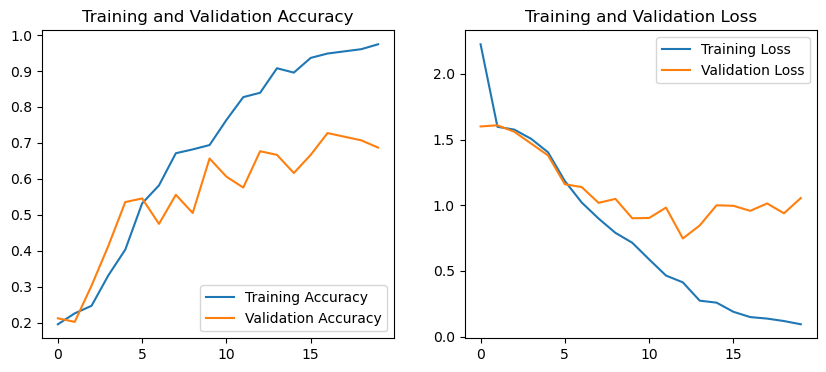

In [188]:
# Visualizing the Model results:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()